# Initialization

## Installs

In [114]:
!pip install ivy-core
!pip install ivy-robot
!pip install jax
!pip install jaxlib
!pip install dm-haiku

## Imports

In [115]:
import ivy
import ivy_mech
import ivy_robot
import numpy as np
import matplotlib.pyplot as plt

## Plot Config

In [116]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]

## Set Backend Framework

In [117]:
ivy.set_framework('jax')

## Helper Functions

In [118]:
def show_2d_spline_path(anchor_coords, interpolated_coords, x_label, y_label, title):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(ivy.to_numpy(interpolated_coords[..., 0]).tolist(),
               ivy.to_numpy(interpolated_coords[..., 1]).tolist(),
               s=15, c=[[0.2, 0.2, 0.8]])
    ax.scatter(ivy.to_numpy(anchor_coords[1:4, 0]).tolist(),
               ivy.to_numpy(anchor_coords[1:4, 1]).tolist(),
               s=80, c=[[1., 1., 1.]], edgecolors=[[0.2, 0.2, 0.8]], linewidths=2)
    ax.scatter(ivy.to_numpy(anchor_coords[0:1, 0]).tolist(),
               ivy.to_numpy(anchor_coords[0:1, 1]).tolist(),
               s=100, c=[[1.0, 0.6, 0.]])
    ax.scatter(ivy.to_numpy(anchor_coords[-1:, 0]).tolist(),
               ivy.to_numpy(anchor_coords[-1:, 1]).tolist(),
               s=100, c=[[0.2, 0.8, 0.2]])
    ax.set_xlabel(x_label, size=15)
    ax.set_ylabel(y_label, size=15).set_rotation(0)
    ax.set_title(title)
    ax.axis('equal')
    plt.show()


def show_full_spline_path(anchor_poses, interpolated_poses, x_label, y_label,
                          title, connect_anchors):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    anchor_poses_trans = ivy.to_numpy(ivy.swapaxes(anchor_poses, 0, 1))
    interpolated_poses_trans = ivy.to_numpy(ivy.swapaxes(interpolated_poses, 0, 1))
    colors = [[0.2, 0.2, 0.8],
              [0.8, 0.2, 0.2],
              [0.2, 0.8, 0.8],
              [0.8, 0.2, 0.8],
              [0.8, 0.8, 0.2]]

    if connect_anchors:
        for a_poses in anchor_poses:
            ax.plot(ivy.to_numpy(a_poses[:, 0]).tolist(),
                    ivy.to_numpy(a_poses[:, 1]).tolist(),
                    c=[0., 0., 0.], linestyle='solid', linewidth=3)

    for a_poses, i_poses, col in zip(anchor_poses_trans, interpolated_poses_trans, colors):

        ax.scatter(ivy.to_numpy(i_poses[..., 0]).tolist(),
                    ivy.to_numpy(i_poses[..., 1]).tolist(),
                   s=15, c=[col])
        ax.scatter(ivy.to_numpy(a_poses[1:4, 0]).tolist(),
                   ivy.to_numpy(a_poses[1:4, 1]).tolist(),
                   s=80, c=[[1., 1., 1.]], edgecolors=[col], linewidths=2)

        ax.scatter(ivy.to_numpy(a_poses[0:1, 0]).tolist(),
                   ivy.to_numpy(a_poses[0:1, 1]).tolist(),
                   s=100, c=[[1.0, 0.6, 0.]])

        ax.scatter(ivy.to_numpy(a_poses[-1:, 0]).tolist(),
                   ivy.to_numpy(a_poses[-1:, 1]).tolist(),
                   s=100, c=[[0.2, 0.8, 0.2]])

    ax.set_xlabel(x_label, size=15)
    ax.set_ylabel(y_label, size=15).set_rotation(0)
    ax.set_title(title)
    ax.axis('equal')
    plt.show()

# Spline Interpolation

## Configuration

In [119]:
num_free_anchors = 3
num_anchors = num_free_anchors + 2
num_samples = 100  # change to any value!
constant_rot_vec = ivy.array([[0., 0., 0.]])
constant_z = ivy.array([[0.]])

## X-Y Positions

In [120]:
# 1 x 2
start_xy = ivy.array([[0., 0.]])  # change to any value!
target_xy = ivy.array([[1., 1.]])  # change to any value!

# 1 x 2
anchor1_xy = ivy.array([[0.6, 0.2]])  # change to any value!
anchor2_xy = ivy.array([[0.5, 0.5]])  # change to any value!
anchor3_xy = ivy.array([[0.4, 0.8]])  # change to any value!

## As 6DOF Poses

In [121]:
# 1 x 6
start_pose = ivy.concatenate((start_xy, constant_z, constant_rot_vec), -1)
anchor1_pose = ivy.concatenate((anchor1_xy, constant_z, constant_rot_vec), -1)
anchor2_pose = ivy.concatenate((anchor2_xy, constant_z, constant_rot_vec), -1)
anchor3_pose = ivy.concatenate((anchor3_xy, constant_z, constant_rot_vec), -1)
target_pose = ivy.concatenate((target_xy, constant_z, constant_rot_vec), -1)

# num_anchors x 6
anchor_poses = ivy.concatenate((start_pose, anchor1_pose, anchor2_pose, anchor3_pose, target_pose), 0)

## Uniform Sampling for Spline

In [122]:
# num_anchors x 1
anchor_points = ivy.expand_dims(ivy.linspace(0., 1., num_anchors), -1)

# num_samples x 1
query_points = ivy.expand_dims(ivy.linspace(0., 1., num_samples), -1)

## Interpolated Spline Poses

In [123]:
# num_samples x 6
interpolated_poses = ivy_robot.sample_spline_path(anchor_points, anchor_poses, query_points)

## X-Y Motion

In [124]:
# num_samples x 2
anchor_xy_positions = anchor_poses[..., 0:2]

# num_samples x 2
interpolated_xy_positions = interpolated_poses[..., 0:2]

## Show X-Y Path

Start point is shown in orange, target point shown in green.

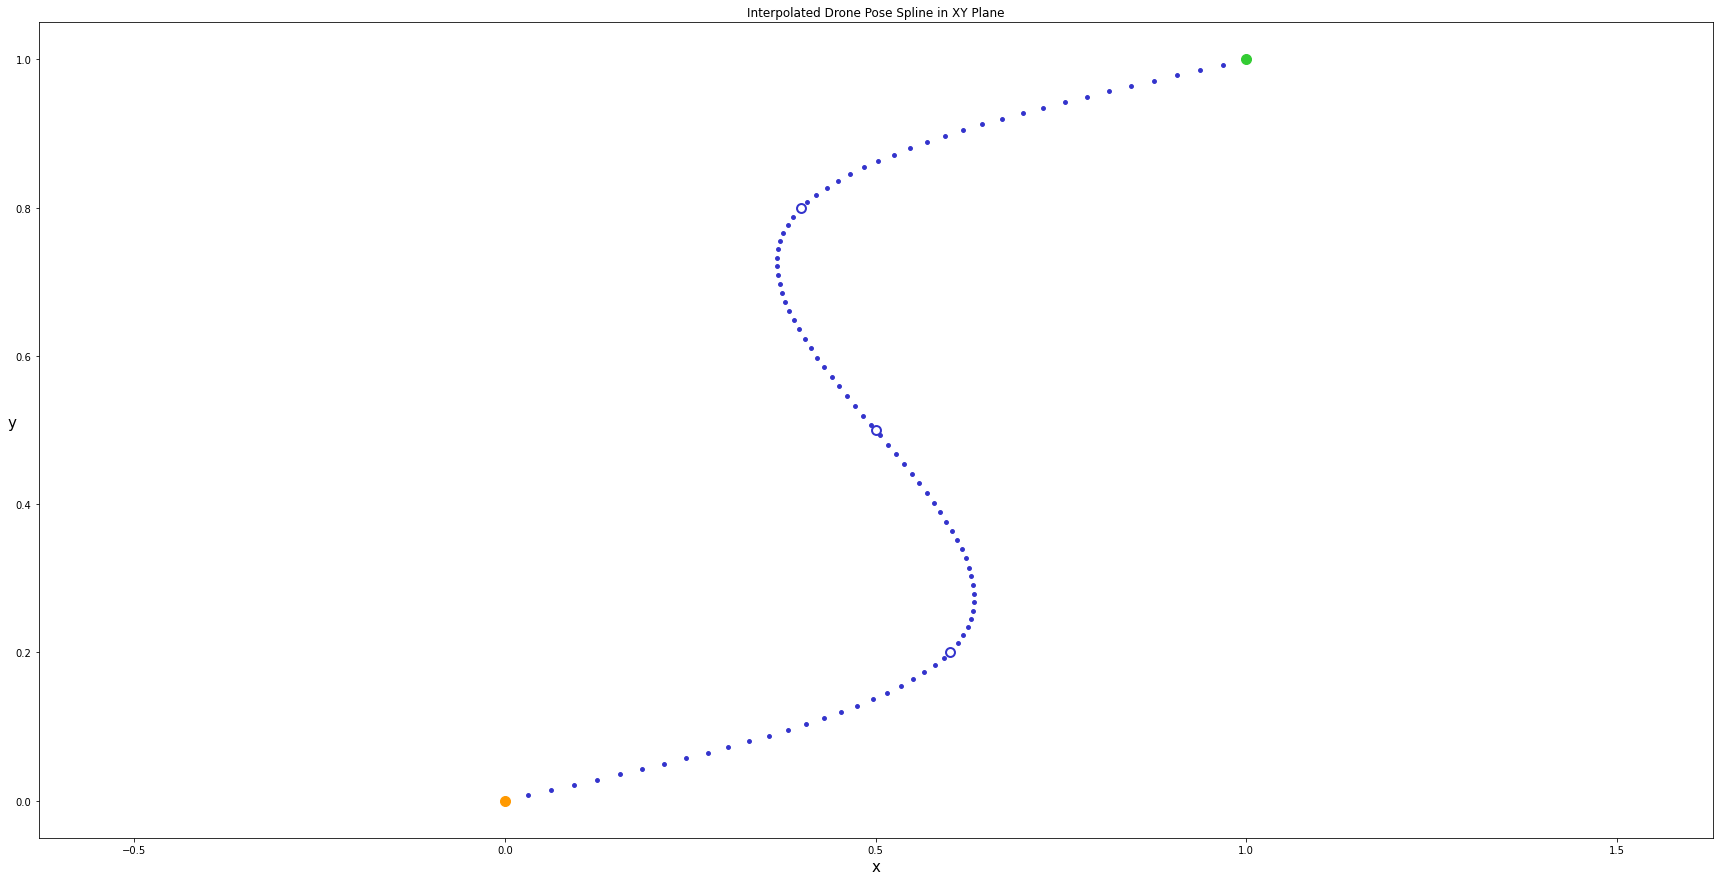

In [125]:
show_2d_spline_path(anchor_xy_positions, interpolated_xy_positions,
                    'x', 'y', 'Interpolated Drone Pose Spline in XY Plane')

# Rigid Mobile

## Drone Relative Body Points

In [126]:
from ivy_robot.rigid_mobile import RigidMobile


# drone relative body points
rel_body_points = ivy.array([[0., 0., 0.],
                             [-0.1, -0.1, 0.],
                             [-0.1, 0.1, 0.],
                             [0.1, -0.1, 0.],
                             [0.1, 0.1, 0.]])  # change to any values!

# create drone as ivy rigid mobile robot
drone = RigidMobile(rel_body_points)

## Rotation Vectors

In [127]:
# 1 x 3
start_rot_vec = ivy.array([[0., 0., 0.]])  # change to any values!
target_rot_vec = ivy.array([[0., 0., np.pi]])  # change to any values!

# 1 x 3
anchor1_rot_vec = ivy.array([[0., 0., np.pi/4]])  # change to any values!
anchor2_rot_vec = ivy.array([[0., 0., 2*np.pi/4]])  # change to any values!
anchor3_rot_vec = ivy.array([[0., 0., 3*np.pi/4]])  # change to any values!

## As 6DOF Poses

In [128]:
# 1 x 6
start_pose = ivy.concatenate((start_xy, constant_z, start_rot_vec), -1)
anchor1_pose = ivy.concatenate((anchor1_xy, constant_z, anchor1_rot_vec), -1)
anchor2_pose = ivy.concatenate((anchor2_xy, constant_z, anchor2_rot_vec), -1)
anchor3_pose = ivy.concatenate((anchor3_xy, constant_z, anchor3_rot_vec), -1)
target_pose = ivy.concatenate((target_xy, constant_z, target_rot_vec), -1)

# num_anchors x 6
anchor_poses = ivy.concatenate((start_pose, anchor1_pose, anchor2_pose, anchor3_pose, target_pose), 0)

## Interpolated Spline Poses

In [129]:
# num_samples x 6
interpolated_poses = ivy_robot.sample_spline_path(anchor_points, anchor_poses, query_points)

## As Matrices

In [130]:
# num_anchors x 3 x 4
anchor_matrices = ivy_mech.rot_vec_pose_to_mat_pose(anchor_poses)

# num_samples x 3 x 4
interpolated_matrices = ivy_mech.rot_vec_pose_to_mat_pose(interpolated_poses)

## Sample Drone Body

In [131]:
# num_anchors x num_body_points x 3
anchor_body_points = drone.sample_body(anchor_matrices)

# num_samples x num_body_points x 3
interpolated_body_points = drone.sample_body(interpolated_matrices)

## Show Spline Path for each Drone Body Point in X-Y Plane

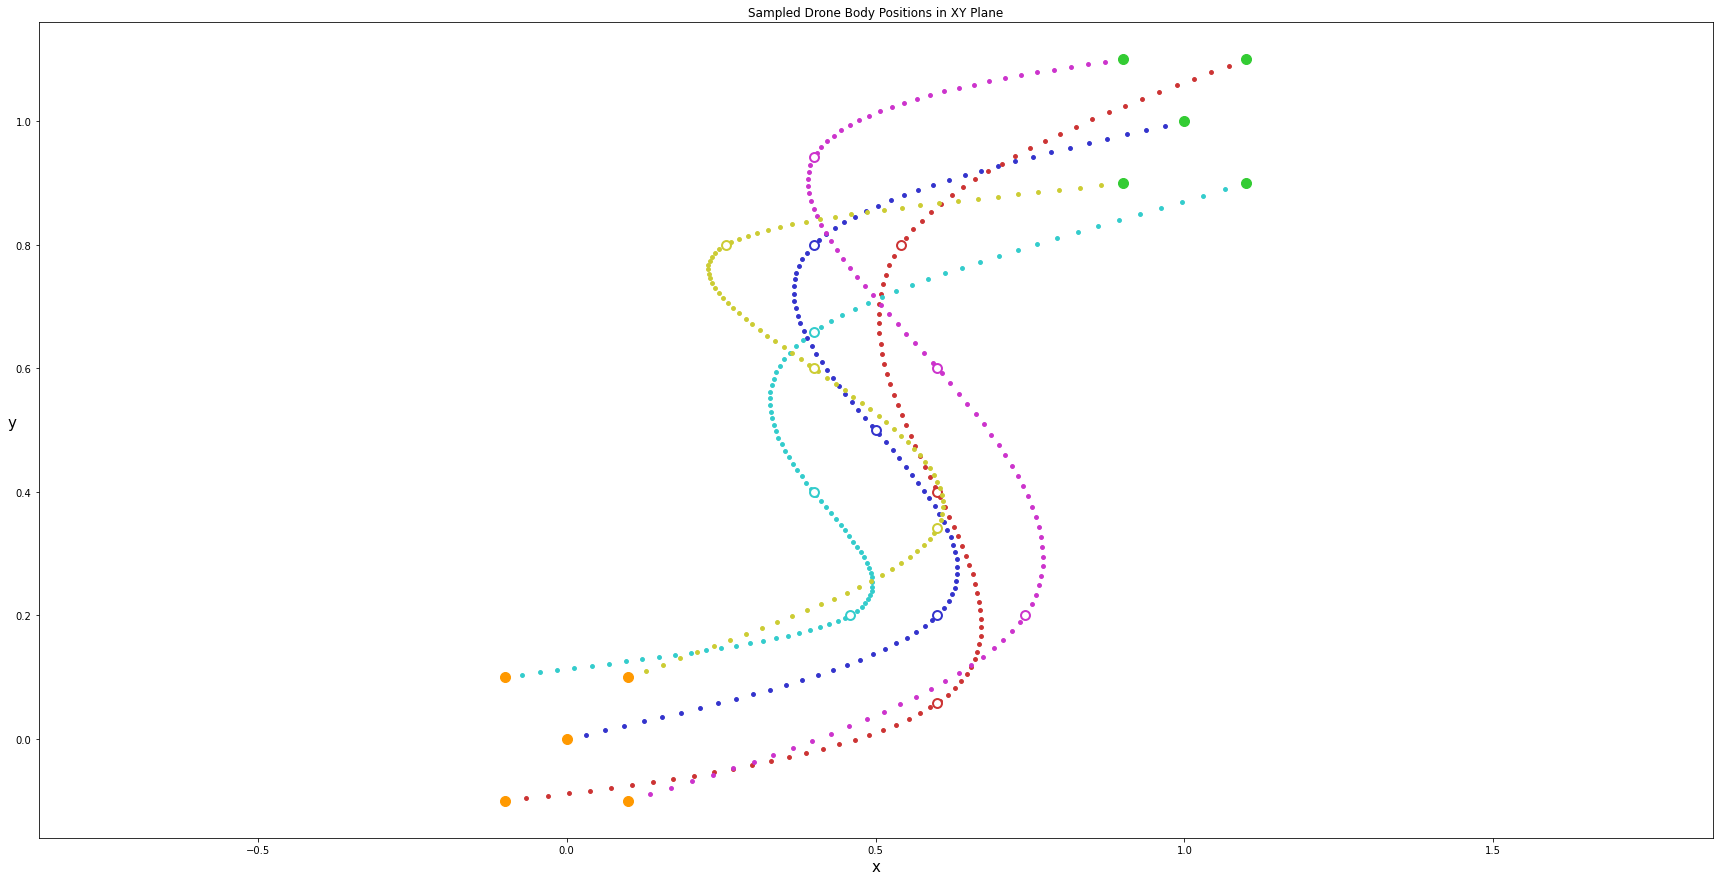

In [132]:
show_full_spline_path(anchor_body_points, interpolated_body_points, 'x', 'y',
                      'Sampled Drone Body Positions in XY Plane', False)

# Manipulator

## Configuration

In [133]:
from ivy_robot.manipulator import Manipulator


class SimpleManipulator(Manipulator):

    # noinspection PyShadowingNames
    def __init__(self, base_inv_ext_mat=None):
        # change Denavit–Hartenberg parameters to any values!
        a_s = ivy.array([0.5, 0.5])
        d_s = ivy.array([0., 0.])
        alpha_s = ivy.array([0., 0.])
        dh_joint_scales = ivy.ones((2,))
        dh_joint_offsets = ivy.array([-np.pi/2, 0.])
        super().__init__(a_s, d_s, alpha_s, dh_joint_scales, dh_joint_offsets,
                         base_inv_ext_mat)

# create manipulator as ivy manipulator
manipulator = SimpleManipulator()

## Joint Angles

In [134]:
# 1 x 2
start_joint_angles = ivy.array([[0., 0.]])
target_joint_angles = ivy.array([[-np.pi/4, -np.pi/4]])

# 1 x 2
anchor1_joint_angles = -ivy.array([[0.2, 0.6]])*np.pi/4
anchor2_joint_angles = -ivy.array([[0.5, 0.5]])*np.pi/4
anchor3_joint_angles = -ivy.array([[0.8, 0.4]])*np.pi/4

# num_anchors x 2
anchor_joint_angles = ivy.concatenate(
    (start_joint_angles, anchor1_joint_angles, anchor2_joint_angles, anchor3_joint_angles,
      target_joint_angles), 0)

## Interpolated Joint Angles

In [135]:
# num_anchors x 2
interpolated_joint_angles = ivy_robot.sample_spline_path(anchor_points, anchor_joint_angles, query_points)

## Sample Links

In [136]:
# num_anchors x num_link_points x 3
anchor_link_points = manipulator.sample_links(anchor_joint_angles, samples_per_metre=5)

# num_anchors x num_link_points x 3
interpolated_link_points = manipulator.sample_links(interpolated_joint_angles, samples_per_metre=5)

## Show Spline Path in Joint-Space

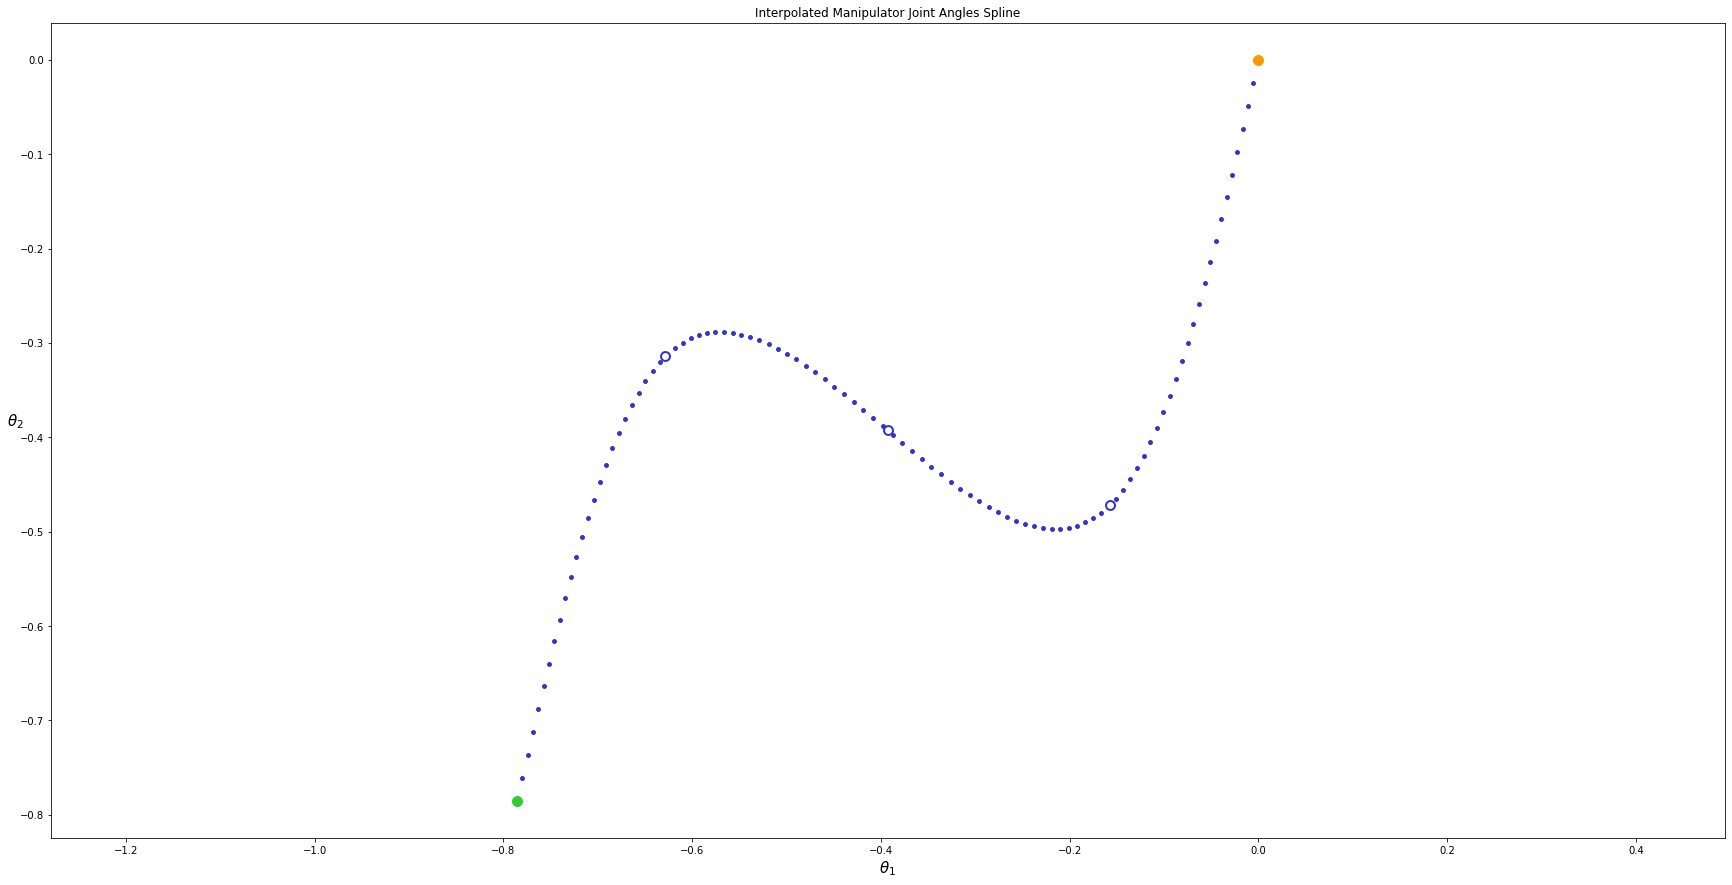

In [137]:
show_2d_spline_path(anchor_joint_angles, interpolated_joint_angles,
                    r'$\theta_1$', r'$\theta_2$',
                    'Interpolated Manipulator Joint Angles Spline')

## Show Spline Path for each Sampled Link Point in X-Y Plane

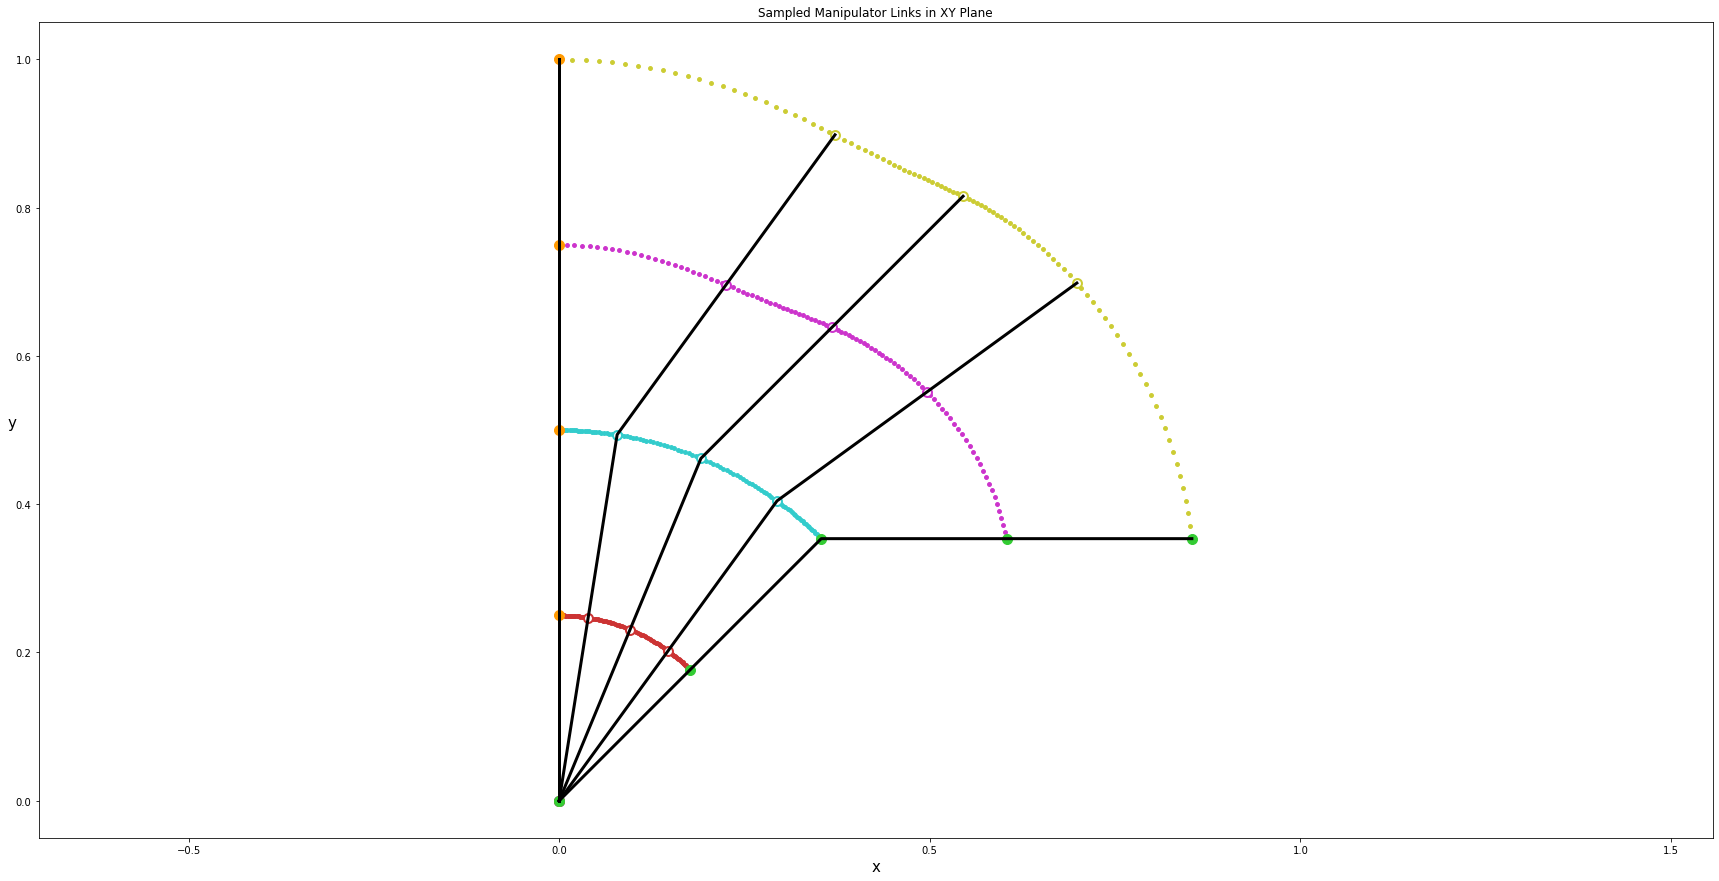

In [138]:
show_full_spline_path(anchor_link_points, interpolated_link_points, 'x', 'y',
                      'Sampled Manipulator Links in XY Plane', True)